In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
import math
import seaborn as sns

In [7]:
# Define file paths 
input_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'

In [15]:
day2_pro_gc_df = pd.read_csv(os.path.join(input_folder,'pro_GC_df_day2.csv'))
day4_pro_gc_df = pd.read_csv(os.path.join(input_folder,'pro_GC_df_day4.csv'))

# For day2
day2_both = day2_pro_gc_df['D2_per_PRDM1'].notna() & day2_pro_gc_df['D2_per_IRF4'].notna()
day2_prdm1_only = day2_pro_gc_df['D2_per_PRDM1'].notna() & day2_pro_gc_df['D2_per_IRF4'].isna()
day2_irf4_only = day2_pro_gc_df['D2_per_PRDM1'].isna() & day2_pro_gc_df['D2_per_IRF4'].notna()

day2_pro_gc_df['predisposition'] = np.where(
    day2_both, 'prdm1&irf4--',
    np.where(
        day2_prdm1_only, 'prdm1--',
        np.where(
            day2_irf4_only, 'irf4--',
            'background'
        )
    )
)

# For day4
day4_both = day4_pro_gc_df['D4_per_PRDM1'].notna() & day4_pro_gc_df['D4_per_IRF4'].notna()
day4_prdm1_only = day4_pro_gc_df['D4_per_PRDM1'].notna() & day4_pro_gc_df['D4_per_IRF4'].isna()
day4_irf4_only = day4_pro_gc_df['D4_per_PRDM1'].isna() & day4_pro_gc_df['D4_per_IRF4'].notna()

day4_pro_gc_df['predisposition'] = np.where(
    day4_both, 'prdm1&irf4--',
    np.where(
        day4_prdm1_only, 'prdm1--',
        np.where(
            day4_irf4_only, 'irf4--',
            'background'
        )
    )
)

In [16]:
day2_pro_gc_df

,index,Z_pert_IRF4,Z_pert_PRDM1,branch,S3_pseudotime,D2_per_IRF4,D2_per_PRDM1,predisposition
0,AAACAGCCAAGGTGCA-1,-0.002850,0.270018,"('S1', 'S0')",0.003650,NaN,NaN,background
1,AAACATGCAAAGCTCC-1,-0.079435,-0.028928,"('S1', 'S0')",0.003573,NaN,NaN,background
2,AAACATGCACAGAAAC-1,0.055560,-0.591037,"('S1', 'S0')",0.003540,NaN,D2_per_PRDM1,prdm1--
3,AAACATGCAGAGAGCC-1,-0.127280,-0.207728,"('S1', 'S0')",0.003654,NaN,NaN,background
4,AAACATGCATTGCGAC-1,-0.342325,-0.319070,"('S1', 'S0')",0.003605,NaN,D2_per_PRDM1,prdm1--
...,...,...,...,...,...,...,...,...
4642,TTTGTTGGTAATAACC-1,-0.434132,-0.225606,"('S1', 'S0')",0.003577,D2_per_IRF4,NaN,irf4--
4643,TTTGTTGGTATTGGAT-1,-0.001193,-0.175720,"('S1', 'S0')",0.003308,NaN,NaN,background
4644,TTTGTTGGTGATGAGG-1,-0.373297,-0.317764,"('S1', 'S0')",0.003544,D2_per_IRF4,D2_per_PRDM1,prdm1&irf4--
4645,TTTGTTGGTGATTTGG-1,-0.573245,-0.737339,"('S1', 'S0')",0.003458,D2_per_IRF4,D2_per_PRDM1,prdm1&irf4--


In [19]:
# count the number of cells in each group
print("day 4: ", day4_pro_gc_df['predisposition'].value_counts())
print("day 2: ", day2_pro_gc_df['predisposition'].value_counts())

# if you want to select all cells with irf4-- 
irf4_cells = day2_pro_gc_df[day2_pro_gc_df['predisposition'].str.contains('irf4--')]
len(irf4_cells)



day 4:  predisposition
background      2668
prdm1--          969
irf4--           505
prdm1&irf4--     298
Name: count, dtype: int64
day 2:  predisposition
background      3110
prdm1--          717
prdm1&irf4--     525
irf4--           295
Name: count, dtype: int64


820

/tmp/ipykernel_24354/3633861326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['S3_pseudotime_z'] = (


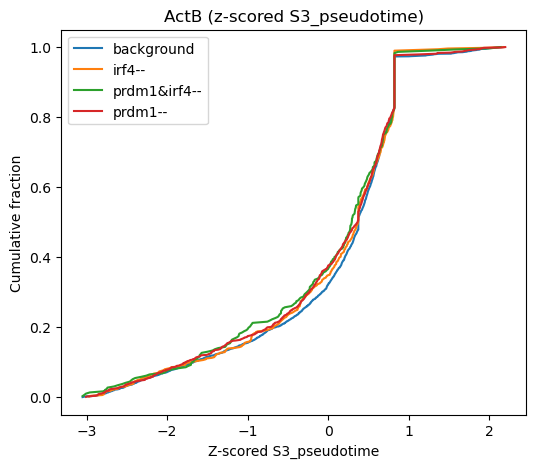

In [23]:
lower = day4_pro_gc_df['S3_pseudotime'].quantile(0.01)
upper = day4_pro_gc_df['S3_pseudotime'].quantile(0.99)
df_no_outliers = day4_pro_gc_df[(day4_pro_gc_df['S3_pseudotime'] >= lower) & (day4_pro_gc_df['S3_pseudotime'] <= upper)]

# Standardize within the filtered dataframe
df_no_outliers['S3_pseudotime_z'] = (
    (df_no_outliers['S3_pseudotime'] - df_no_outliers['S3_pseudotime'].mean()) /
    df_no_outliers['S3_pseudotime'].std()
)
# CDF plot 

plt.figure(figsize=(6,5))
for group, group_df in df_no_outliers.groupby('predisposition'):
    sorted_vals = np.sort(group_df['S3_pseudotime_z'])
    cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, cdf, label=group)
plt.xlabel('Z-scored S3_pseudotime')
plt.ylabel('Cumulative fraction')
plt.legend()
plt.title('ActB (z-scored S3_pseudotime)')
plt.show()

/tmp/ipykernel_24354/3301901584.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_no_outliers, x='predisposition', y='S3_pseudotime', palette='Set2')


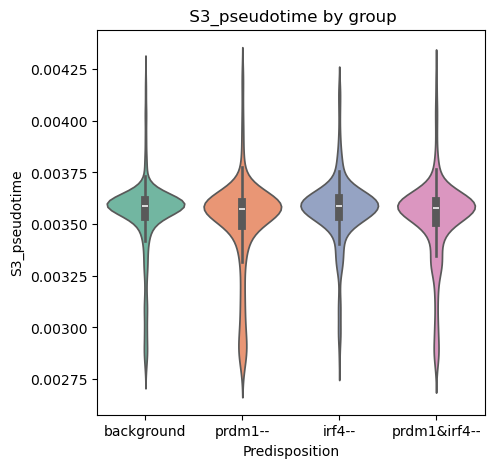

In [22]:
# Violin plot
plt.figure(figsize=(5,5))
sns.violinplot(data=df_no_outliers, x='predisposition', y='S3_pseudotime', palette='Set2')
plt.xlabel('Predisposition')
plt.ylabel('S3_pseudotime')
plt.title(' S3_pseudotime by group')
plt.show()


In [ ]:
proGC_pseudotimes = df_no_outliers[df_no_outliers['predisposition'] == 'pro-GC']['S3_pseudotime']
background_pseudotimes = df_no_outliers[df_no_outliers['predisposition'] == 'background']['S3_pseudotime']
# Convert to pandas Series
proGC_pseudotimes = pd.Series(proGC_pseudotimes, name='pro-GC')
background_pseudotimes = pd.Series(background_pseudotimes, name='background')


In [ ]:
# Combine for easier plotting with Seaborn's hue
df_plot = pd.concat([
    pd.DataFrame({'pseudotime': proGC_pseudotimes, 'group': 'pro-GC'}),
    pd.DataFrame({'pseudotime': background_pseudotimes, 'group': 'background'})
])

In [ ]:
df_plot

In [ ]:
plt.figure(figsize=(8, 6))

# Plot KDEs
ax = sns.kdeplot(data=df_plot, x='pseudotime', hue='group', 
            fill=True, alpha=0.5, common_norm=False, # common_norm=False normalizes each KDE independently
            palette={'pro-GC': '#ff7f0e', 'background': '#1f77b4'},
            legend='full') # Example colors, match your ECDF


plt.title('S3_pseudotime by Group')
plt.xlabel('S3_pseudotime')
plt.ylabel('Density')
# Manually create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ff7f0e', edgecolor='k', label='pro-GC', alpha=0.5),
    Patch(facecolor='#1f77b4', edgecolor='k', label='background', alpha=0.5)
]
plt.legend(handles=legend_elements, title='Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

# Plot Histograms with density normalization
sns.histplot(data=df_plot, x='pseudotime', hue='group',
             stat='density', common_norm=False, # 'density' normalizes each histogram
             kde=False, # Set to True if you want a KDE line on top of each histogram
             alpha=0.6,
             bins=30, # Adjust bins as needed
             element='step', # 'step' can be cleaner for overlaps than 'bar'
             palette={'pro-GC': '#ff7f0e', 'background': '#1f77b4'})

# Alternatively, for more control or if you prefer bars:
# sns.histplot(data=proGC_pseudotimes, label='pro-GC', stat='density', color='#ff7f0e', alpha=0.6, bins=30, kde=False)
# sns.histplot(data=background_pseudotimes, label='background', stat='density', color='#1f77b4', alpha=0.6, bins=30, kde=False)


plt.title('Histogram of S3_pseudotime by Group')
plt.xlabel('S3_pseudotime')
plt.ylabel('Density')
# Manually create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ff7f0e', edgecolor='k', label='pro-GC', alpha=0.5),
    Patch(facecolor='#1f77b4', edgecolor='k', label='background', alpha=0.5)
]
plt.legend(handles=legend_elements, title='Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure proGC_pseudotimes and background_pseudotimes are defined ---
if 'proGC_pseudotimes' not in locals() or 'background_pseudotimes' not in locals():
    print("Error: proGC_pseudotimes or background_pseudotimes not defined.")
    # Add example data for testing if needed, or exit
    # proGC_pseudotimes = pd.Series(np.random.normal(0.0030, 0.0002, 100), name='pro-GC')
    # background_pseudotimes = pd.Series(np.random.normal(0.0033, 0.0003, 300), name='background')


if proGC_pseudotimes.empty:
    print("pro-GC group is empty. Cannot perform downsampling or plotting.")
else:
    # 1. Determine Target Size
    n_proGC = len(proGC_pseudotimes)
    n_background_original = len(background_pseudotimes)
    print(f"Original pro-GC count: {n_proGC}")
    print(f"Original background count: {n_background_original}")

    # 2. Downsample `background` if it's larger
    if n_background_original > n_proGC:
        print(f"Downsampling background cells from {n_background_original} to {n_proGC} (to match pro-GC).")
        # Randomly sample 'n_proGC' cells from the background group
        # Setting a random_state for reproducibility
        background_pseudotimes_downsampled = background_pseudotimes.sample(n=n_proGC, random_state=42)
    elif n_background_original < n_proGC:
        print(f"Warning: Background count ({n_background_original}) is already less than pro-GC count ({n_proGC}). Using all background cells.")
        background_pseudotimes_downsampled = background_pseudotimes.copy() # Use all
    else:
        print("Background and pro-GC groups are already size-matched.")
        background_pseudotimes_downsampled = background_pseudotimes.copy()

    # 3. Combine Data (using original pro-GC and downsampled background)
    df_proGC_final = pd.DataFrame({'pseudotime': proGC_pseudotimes, 'group': 'pro-GC'})
    df_background_final = pd.DataFrame({'pseudotime': background_pseudotimes_downsampled, 'group': 'background'})
    df_combined = pd.concat([df_proGC_final, df_background_final], ignore_index=True)

    if df_combined.empty or df_combined['pseudotime'].isnull().all():
        print("Combined DataFrame (post-downsampling) is empty or all pseudotimes are NaN. Cannot proceed.")
    else:
        # 4. Define Bins (adjust based on your data's characteristics)
        min_pt = df_combined['pseudotime'].min()
        max_pt = df_combined['pseudotime'].max()

        # !!! IMPORTANT: ADJUST THESE BIN EDGES based on your histogram/KDE AFTER considering downsampling effects on range !!!
        bins = [
            min_pt, 0.0028, 0.0029, 0.0030, 0.0031, 0.0032, 0.0033, 0.0034, 0.0035, max_pt
        ]
        bins = sorted(list(set(bins)))
        if len(bins) < 2: bins = [min_pt, max_pt]

        bin_labels = []
        bin_medians_for_x = []
        if len(bins) > 1:
            for i in range(len(bins) - 1):
                label = f"{bins[i]:.4f}-{bins[i+1]:.4f}"
                bin_labels.append(label)
                bin_medians_for_x.append((bins[i] + bins[i+1]) / 2)
        
        if not bin_labels and len(bins) == 2:
            bin_labels = [f"{bins[0]:.4f}-{bins[1]:.4f}"]
            bin_medians_for_x = [(bins[0] + bins[1]) / 2]
        elif not bin_labels and len(bins) > 1:
             print("Error: Bin labels could not be generated.")


        if bin_labels:
            df_combined['pseudotime_bin_label'] = pd.cut(df_combined['pseudotime'],
                                                         bins=bins,
                                                         labels=bin_labels,
                                                         right=False,
                                                         include_lowest=True)

            # 5. Calculate Proportions within Bins
            binned_counts = df_combined.groupby(['pseudotime_bin_label', 'group'], observed=False).size().unstack(fill_value=0)

            if 'pro-GC' not in binned_counts.columns: binned_counts['pro-GC'] = 0
            if 'background' not in binned_counts.columns: binned_counts['background'] = 0
            
            binned_counts_percent = binned_counts.apply(lambda x: (x / x.sum()) * 100 if x.sum() > 0 else 0, axis=1)
            
            label_to_median_map = dict(zip(bin_labels, bin_medians_for_x))
            binned_counts_percent['bin_median_x'] = binned_counts_percent.index.map(label_to_median_map)
            binned_counts_percent = binned_counts_percent.sort_values('bin_median_x')

# --- Start of the modified plotting section ---
if 'binned_counts_percent' in locals() and not binned_counts_percent.empty:
    fig, ax = plt.subplots(figsize=(12, 7))
    x_positions = binned_counts_percent['bin_median_x']
    
    # Calculate bar width more dynamically
    unique_x_sorted = sorted(np.unique(x_positions))
    if len(unique_x_sorted) > 1:
        min_diff = np.min(np.diff(unique_x_sorted))
        bar_width = 0.8 * min_diff if min_diff > 0 else 0.8
    elif len(unique_x_sorted) == 1 :
        bar_width = 0.8 
    else: 
        bar_width = 0.8

    # Plot pro-GC bars
    ax.bar(x_positions, binned_counts_percent['pro-GC'],
           label='pro-GC', color='#ff7f0e', width=bar_width) # Your pro-GC color

    # Plot background bars on top of pro-GC bars
    ax.bar(x_positions, binned_counts_percent['background'],
           bottom=binned_counts_percent['pro-GC'], 
           label='background (downsampled)', color='#1f77b4', width=bar_width) # Your background color

    ax.set_xlabel("Median S3_pseudotime of Bin")
    ax.set_ylabel("Percentage of Cells in Bin (%)")
    ax.set_title("Composition of Pseudotime Bins by Group (Day 2, Background Downsampled)")
    ax.set_ylim(0, 105) 
    
    if not x_positions.empty:
        ax.set_xticks(x_positions)
        ax.set_xticklabels(binned_counts_percent.index, rotation=45, ha="right")
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    ax.axhline(50, color='dimgray', linestyle='--', alpha=0.8, linewidth=1.2, label='50% mark')
    ax.legend(title="Group")
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate plot: 'binned_counts_percent' is not defined or is empty.")